In [1]:
%load_ext zipline

In [26]:
%%zipline --start 2015-1-1 --end 2018-1-1 --output result.pickle --no-benchmark

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=5)]
    window_length = 21

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')


C:\Users\June\anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\June\anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,None,0.0,NaN,None,0.000000e+00,1.000000e+07,0.000,0.000,...,0.000,0.000,0,NaN,1.000000e+07,0.000,0.000,1,[],0.0
2015-01-05 21:00:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000e+00,1.000000e+07,0.000,0.000,...,0.000,0.000,0,NaN,1.000000e+07,0.000,0.000,2,[],0.0
2015-01-06 21:00:00+00:00,0.000474,-0.000052,None,0.0,0.0,None,-1.575452e+06,8.424548e+06,1574934.520,1574934.520,...,0.000,0.000,0,-9.165151,1.000000e+07,0.000,0.000,3,"[{'amount': 11289, 'dt': 2015-01-06 21:00:00+0...",0.0
2015-01-07 21:00:00+00:00,0.014265,0.001728,None,0.0,0.0,None,0.000000e+00,8.424548e+06,1592726.750,1592726.750,...,0.000,0.000,0,265.188978,8.424548e+06,1574934.520,1574934.520,4,[],0.0
2015-01-08 21:00:00+00:00,0.017333,0.003876,None,0.0,0.0,None,0.000000e+00,8.424548e+06,1614208.810,1614208.810,...,0.000,0.000,0,531.622117,8.424548e+06,1592726.750,1592726.750,5,[],0.0
2015-01-09 21:00:00+00:00,0.017355,0.003445,None,0.0,0.0,None,0.000000e+00,8.424548e+06,1609899.740,1609899.740,...,0.000,0.000,0,51.607464,8.424548e+06,1614208.810,1614208.810,6,[],0.0
2015-01-12 21:00:00+00:00,0.017532,0.002765,None,0.0,0.0,None,0.000000e+00,8.424548e+06,1603100.630,1603100.630,...,0.000,0.000,0,20.642576,8.424548e+06,1609899.740,1609899.740,7,[],0.0
2015-01-13 21:00:00+00:00,0.016242,0.003264,None,0.0,0.0,None,3.280543e+06,1.170509e+07,-1672449.310,-1672449.310,...,-4049552.120,-4049552.120,10,22.786075,8.424548e+06,1603100.630,1603100.630,8,"[{'amount': -11289, 'dt': 2015-01-13 21:00:00+...",0.0
2015-01-14 21:00:00+00:00,0.025319,0.007514,None,0.0,0.0,None,0.000000e+00,1.170509e+07,-1629954.905,-1629954.905,...,-4017629.085,-4017629.085,10,49.367733,1.170509e+07,-1672449.310,-1672449.310,9,[],0.0
2015-01-15 21:00:00+00:00,0.026534,0.010678,None,0.0,0.0,None,0.000000e+00,1.170509e+07,-1598307.120,-1598307.120,...,-3926647.850,-3926647.850,10,66.452806,1.170509e+07,-1629954.905,-1629954.905,10,[],0.0


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

perf = pd.read_pickle('single_factor.pickle') # read in perf DataFrame
perf.head()

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2015-01-02 21:00:00+00:00,NaN,0.000000,None,0.0,NaN,None,0.000000e+00,1.000000e+07,0.00,0.00,...,0.000,0.000,0,NaN,1.000000e+07,0.00,0.00,1,[],0.0
2015-01-05 21:00:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000e+00,1.000000e+07,0.00,0.00,...,0.000,0.000,0,NaN,1.000000e+07,0.00,0.00,2,[],0.0
2015-01-06 21:00:00+00:00,0.003482,-0.000380,None,0.0,0.0,None,-3.118062e+06,6.881938e+06,3114262.86,3114262.86,...,-1617262.705,-1617262.705,4,-9.165151,1.000000e+07,0.00,0.00,3,"[{'amount': 18433, 'dt': 2015-01-06 21:00:00+0...",0.0
2015-01-07 21:00:00+00:00,0.011564,0.000905,None,0.0,0.0,None,0.000000e+00,6.881938e+06,3127113.44,3127113.44,...,-1629987.410,-1629987.410,4,18.918320,6.881938e+06,3114262.86,3114262.86,4,[],0.0
2015-01-08 21:00:00+00:00,0.044725,0.007277,None,0.0,0.0,None,0.000000e+00,6.881938e+06,3190835.20,3190835.20,...,-1645106.080,-1645106.080,4,135.877107,6.881938e+06,3127113.44,3127113.44,5,[],0.0


In [28]:
perf.columns

Index(['algo_volatility', 'algorithm_period_return', 'alpha',
       'benchmark_period_return', 'benchmark_volatility', 'beta',
       'capital_used', 'ending_cash', 'ending_exposure', 'ending_value',
       'excess_return', 'factor_data', 'gross_leverage', 'long_exposure',
       'long_value', 'longs_count', 'max_drawdown', 'max_leverage',
       'net_leverage', 'orders', 'period_close', 'period_label', 'period_open',
       'pnl', 'portfolio_value', 'positions', 'prices', 'returns', 'sharpe',
       'short_exposure', 'short_value', 'shorts_count', 'sortino',
       'starting_cash', 'starting_exposure', 'starting_value', 'trading_days',
       'transactions', 'treasury_period_return'],
      dtype='object')

C:\Users\June\anaconda3\envs\env_zipline\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


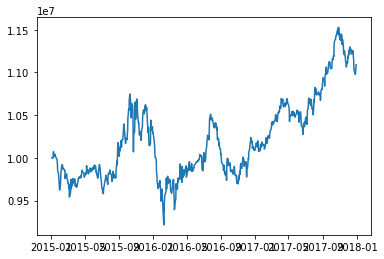

In [29]:
x = perf['portfolio_value']
plt.plot(x.index,x.values)

C:\Users\June\anaconda3\envs\env_zipline\lib\site-packages\pandas\plotting\_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)


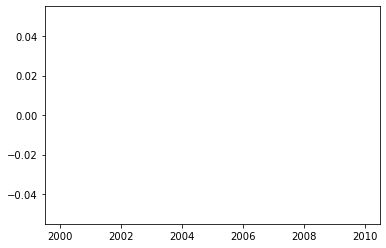

In [6]:
x = perf['beta']
plt.plot(x.index,x.values)